## 1. Descriptive Analysis of the Data

In this section, we explore the training dataset to understand its structure, variables, and missing values.


In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("application_train.csv")
df.shape, df.columns[:10]

((307511, 122),
 Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
        'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
        'AMT_CREDIT', 'AMT_ANNUITY'],
       dtype='object'))

### 1.1 Dataset Overview

In [91]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Missing Values

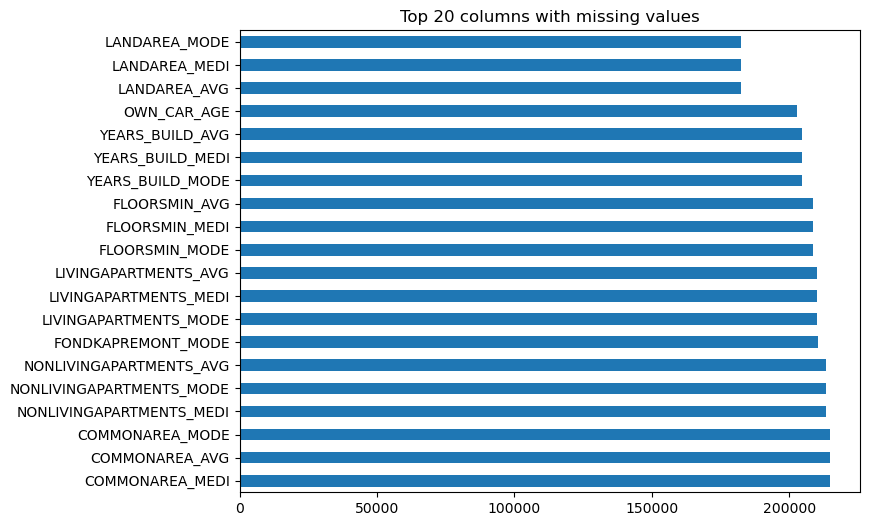

In [93]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values.head(20)

#Visualisation 

missing_values.head(20).plot(kind='barh', figsize=(8,6))
plt.title("Top 20 columns with missing values")
plt.show()

### 1.3 Target Variable (`TARGET`)

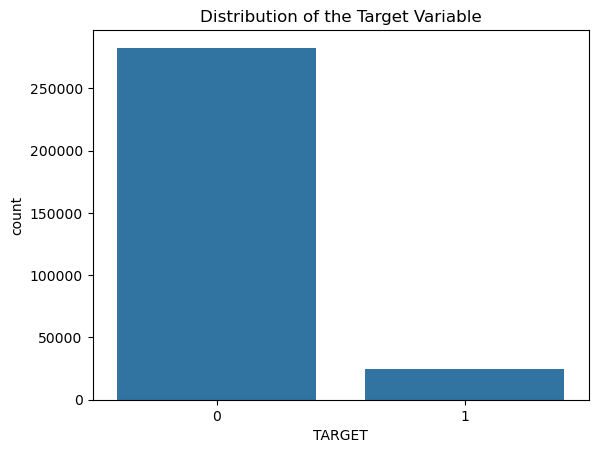

In [97]:
df['TARGET'].value_counts(normalize=True)
sns.countplot(x='TARGET', data=df)
plt.title("Distribution of the Target Variable")
plt.show()

### 1.4 Key Features Exploration

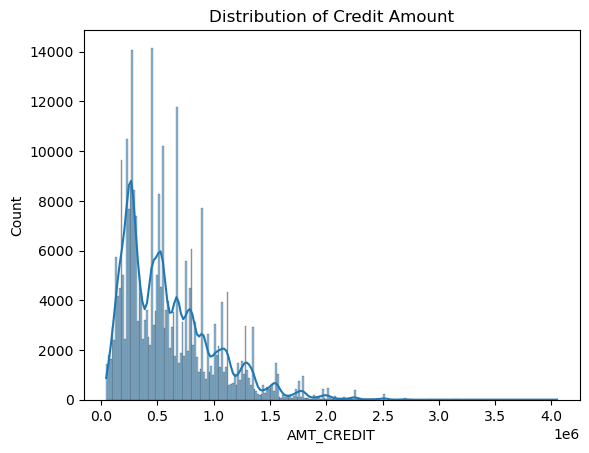

In [99]:
df[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']].describe()

#Visualisation 

sns.histplot(df['AMT_CREDIT'], kde=True)
plt.title("Distribution of Credit Amount")
plt.show()

#sns.histplot(df['AMT_INCOME_TOTAL'], kde=True)
#plt.title("Distribution of Income")
#plt.show()

### 1.5 Correlation between numerical variables

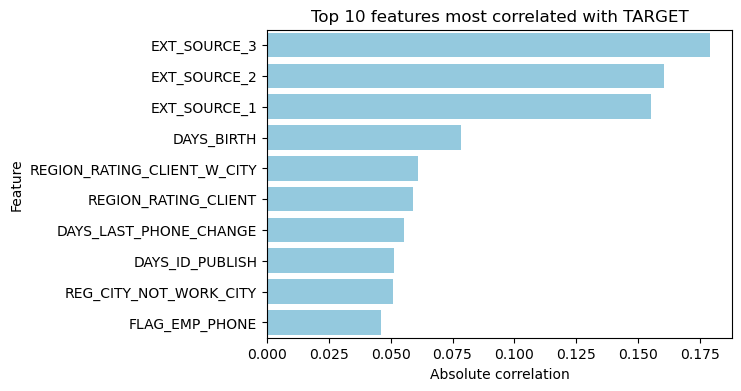

In [101]:
# top 10 features les plus corrélées
corr = df.corr(numeric_only=True)['TARGET'].abs().sort_values(ascending=False)[1:11]

plt.figure(figsize=(6, 4))
sns.barplot(x=corr.values, y=corr.index, color='skyblue')  # utiliser color= au lieu de palette=
plt.title("Top 10 features most correlated with TARGET")
plt.xlabel("Absolute correlation")
plt.ylabel("Feature")
plt.show()

### Conclusion of Step 1 — Descriptive Analysis

The exploration of the `application_train.csv` dataset reveals several key insights:

- The target variable `TARGET` is **highly imbalanced**, with around **91% of non-default clients** (`TARGET = 0`) and **0.9 of defaulting clients** (`TARGET = 1`).  
  This confirms that we are dealing with a **binary classification problem with class imbalance**.  
  In future stages, this task will be extended to a **multiclass problem** to better capture varying levels of credit risk.

- A **large number of missing values** are observed across several columns, especially in credit bureau and external source features.  
  Proper handling of missing data will be necessary during preprocessing.

- The **distribution of credit amounts (`AMT_CREDIT`)** is right-skewed: most clients request relatively small loans (peak around 80,000), and fewer clients request very high amounts.

- The **distribution of income (`AMT_INCOME_TOTAL`)** is extremely uneven, with most clients concentrated at low income levels.
The histogram appears almost flat near zero on the count axis, suggesting the presence of large outliers or potential scaling issues.

- The **correlation with the target** shows that the most informative variables are mainly:

    - EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1 (external credit scores)

    - DAYS_BIRTH (client age)
These variables will likely be important for modeling.

Overall, this descriptive analysis provides a first understanding of the dataset’s structure and challenges: **imbalanced target, missing values, skewed distributions, and complex feature interactions**.


## 2. Implementation of the Necessary Pre-processing

In this step, we prepare the dataset for modeling by handling missing values, encoding categorical features, scaling numerical features, and splitting the data into training and testing sets.


### 2.1 Handling Missing Values

We check which features have missing values and decide on appropriate strategies: 
- Drop columns with too many missing values.
- Impute missing numerical values with median.
- Impute missing categorical values with mode.


In [106]:
# Identifier les colonnes avec NaN
missing_values = df.isnull().sum()
missing_cols = missing_values[missing_values > 0].index.tolist()

# Colonnes avec trop de NaN à supprimer (par exemple >30% des lignes)
threshold = 0.3 * len(df)
cols_to_drop = [col for col in missing_cols if missing_values[col] > threshold]
df = df.drop(columns=cols_to_drop)

# Imputer les colonnes numériques restantes par la médiane
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())  # assignation directe

# Imputer les colonnes catégorielles par la valeur la plus fréquente
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])  # assignation directe
#Visualition 
df.isnull().sum().head(20)

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
AMT_GOODS_PRICE               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
dtype: int64

### 2.2 Encoding Categorical Variables

Categorical features are converted to numeric representations using one-hot encoding to be usable by machine learning models.

In [108]:
# One-hot encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

#Vérification 
df.shape
df.dtypes.value_counts()

bool       95
int64      41
float64    20
Name: count, dtype: int64

### 2.3 Scaling Numerical Features

Numerical features are standardized so that all variables have similar scales, which helps some models converge faster.

Colonnes normalisées : 59 premières : ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
SK_ID_CURR non normalisé - premiers valeurs : [100002 100003 100004 100006 100007]
SK_ID_CURR type : int64


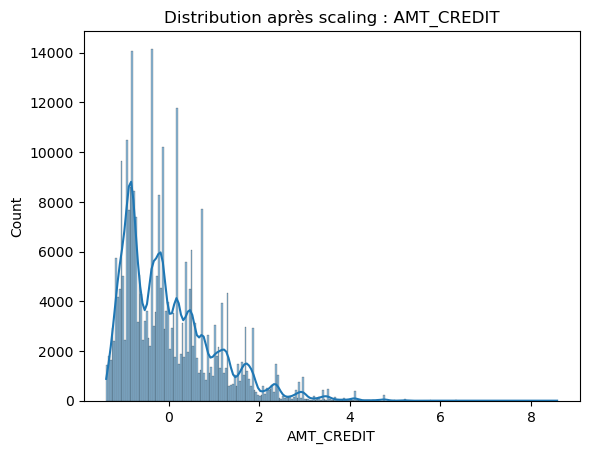

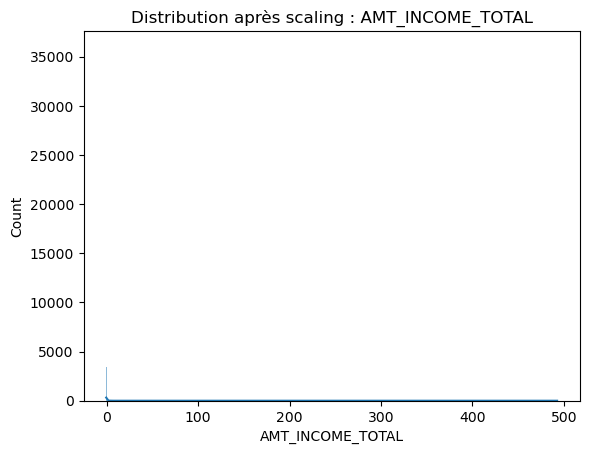

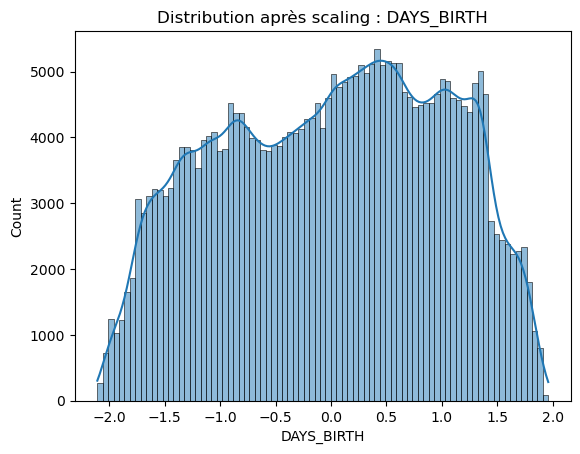

In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

cols_to_exclude = ['TARGET', 'SK_ID_CURR']
if 'SK_ID_BUREAU' in num_cols:
    cols_to_exclude.append('SK_ID_BUREAU')

for col in cols_to_exclude:
    if col in num_cols:
        num_cols.remove(col)

df[num_cols] = scaler.fit_transform(df[num_cols])

# AJOUTEZ CETTE VÉRIFICATION :
print(f"Colonnes normalisées : {len(num_cols)} premières : {num_cols[:5]}")
print(f"SK_ID_CURR non normalisé - premiers valeurs : {df['SK_ID_CURR'].head().values}")
print(f"SK_ID_CURR type : {df['SK_ID_CURR'].dtype}")

#Visualisation
for col in ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH']:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution après scaling : {col}')
    plt.show()

### 2.4 Train/Test Split

We separate features (X) and target (y) and split the dataset into training and testing sets for model evaluation.

In [112]:
from sklearn.model_selection import train_test_split

X = df.drop('TARGET', axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Vérification 
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("Train TARGET distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest TARGET distribution:")
print(y_test.value_counts(normalize=True))

X_train shape: (246008, 155)
X_test shape: (61503, 155)
y_train shape: (246008,)
y_test shape: (61503,)
Train TARGET distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Test TARGET distribution:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


### Conclusion of Step 2 — Preprocessing

After the preprocessing stage, our dataset is ready for modeling:

- **Missing values:** all critical columns were imputed (median for numerical variables, mode for categorical ones), and columns with too many missing values were removed.  
- **Categorical variables:** transformed into binary variables using One-Hot Encoding, making them usable by machine learning models.  
- **Numerical variables:** standardized with StandardScaler, centered around 0 with a standard deviation close to 1, ensuring a consistent scale across all continuous features.  
- **Train/Test split:** the dataset was divided into 80% for training and 20% for testing, while preserving the target class proportions through stratification.  

Result: a dataset that is **fully numerical, with no missing values**, properly scaled, and ready to train a baseline model.

## 3. Formalisation of the Problem

The goal of this project is to predict **credit risk** for clients using machine learning. 

- **Current problem:** binary classification (`TARGET = 0` for non-defaulters, `TARGET = 1` for defaulters)  
- **Future extension:** we aim to convert this into a **multiclass problem** to reflect different levels of risk.

### 3.1 Features and Target

- **Features (X):** all processed columns after preprocessing (numeric + one-hot encoded categorical)  
- **Target (y):** 'TARGET', indicating whether a client defaulted or not

In [115]:
# Vérification des dimensions des jeux
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Vérification rapide de la distribution de la cible
print("\nTrain TARGET distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest TARGET distribution:")
print(y_test.value_counts(normalize=True))

X_train shape: (246008, 155)
X_test shape: (61503, 155)
y_train shape: (246008,)
y_test shape: (61503,)

Train TARGET distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Test TARGET distribution:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


### 3.2 From Binary to Multiclass

Although the dataset is currently binary, we plan to extend it to a **multiclass classification problem** by defining multiple risk levels:

- Low risk (clients unlikely to default)  
- Medium risk (clients with moderate risk)  
- High risk (clients highly likely to default)

This will allow the model to provide **more nuanced predictions** for credit risk management.

### 3.3 Other Available Files

Additional files in the dataset could be used in future steps to improve the model:

- `bureau.csv`, `bureau_balance.csv`, `POS_CASH_balance.csv`, `credit_card_balance.csv`, `previous_application.csv`, `installments_payments.csv`  
- These files contain historical information about clients' credits and payments.  
- For this first step, we focus on **`application_train.csv`**, but later we can merge these files to enrich the dataset and potentially improve predictions.

### Conclusion of Step 3

- The problem is currently a **binary classification** with an imbalanced target (91% non-defaulters / 9% defaulters).  
- Features (`X_train` / `X_test`) and target (`y_train` / `y_test`) are **ready and verified**, with the train/test split correctly stratified.  
- In future steps, the problem will be extended to **multiclass classification** (low, medium, high risk) to provide more detailed credit risk predictions.  
- Additional dataset files exist and can be merged later to enrich the model.


## 4. Baseline Model Selection

For this first step, we select a simple and interpretable **baseline model** to evaluate the dataset and preprocessing:

- **Model chosen:** Logistic Regression  
- **Reason:**  
  - Suitable for **binary classification**  
  - Easy to **interpret coefficients**  
  - Provides a **reference performance** before testing more complex models

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Création du modèle
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement
baseline_model.fit(X_train, y_train)

# Prédictions
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:,1]

C:\Users\cassa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4.2 Model Evaluation

We evaluate the baseline logistic regression model using:

- **Accuracy**: proportion of correctly predicted samples  
- **ROC-AUC**: ability to discriminate between defaulters and non-defaulters  
- **Classification report**: precision, recall, f1-score

In [123]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9192397118839731
ROC-AUC: 0.7378037503815755

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.49      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



### Conclusion of Step 4

- The **logistic regression baseline model** was trained and evaluated on the processed dataset.  
- The model achieved an **accuracy of 91.9%** and a **ROC-AUC of 0.744**, providing a reference performance.  
- While the model predicts non-defaulters (class 0) very well, it struggles to correctly identify defaulters (class 1) due to the dataset imbalance.  
- This baseline highlights the need for **future improvements**, such as additional features, dataset rebalancing, or more complex models, to better detect high-risk clients.

## 5. Transforming the Problem into a Multiclass Setting

We transform the original binary target variable `TARGET` into a new multiclass variable called `RISK_CLASS`.  
The goal is to better model credit risk and overcome the imbalance of the original target (default rate ≈ 8%).

Risk classes are defined as:

- **Class 0 – Low Risk**: clients with very low probability of default  
- **Class 1 – Medium Risk**: clients with moderate probability of default  
- **Class 2 – High Risk**: clients with high probability of default  

This allows us to train richer multiclass models instead of a severely imbalanced binary classifier.

In [127]:
# Create RISK_CLASS for train set 
df_train_risk = X_train.copy()
df_train_risk['TARGET'] = y_train.values  # binary target

# Use baseline logistic regression probabilities as risk score for train
risk_score_train = baseline_model.predict_proba(X_train)[:,1]  # probs of default
df_train_risk['risk_score'] = risk_score_train

### 5.1 Building a Risk Score and Creating Classes

We use the predicted probabilities from the baseline logistic regression as a continuous risk score and split it into 3 categories using quantiles (0–70% Low, 70–90% Medium, 90–100% High).

In [130]:
# Define quantile thresholds
q1_train = np.quantile(df_train_risk["risk_score"], 0.70)
q2_train = np.quantile(df_train_risk["risk_score"], 0.90)

# Function to classify into three risk classes
def risk_classify(score, q1, q2):
    if score < q1:
        return 0   # Low Risk
    elif score < q2:
        return 1   # Medium Risk
    else:
        return 2   # High Risk

# Apply function to create RISK_CLASS
df_train_risk["RISK_CLASS"] = df_train_risk["risk_score"].apply(lambda x: risk_classify(x, q1_train, q2_train))

### 5.2 Distribution Check

We examine the proportion of clients in each risk class to ensure reasonable balance.

In [132]:
# Check distribution
df_train_risk["RISK_CLASS"].value_counts(normalize=True)

RISK_CLASS
0    0.699998
1    0.200002
2    0.100001
Name: proportion, dtype: float64

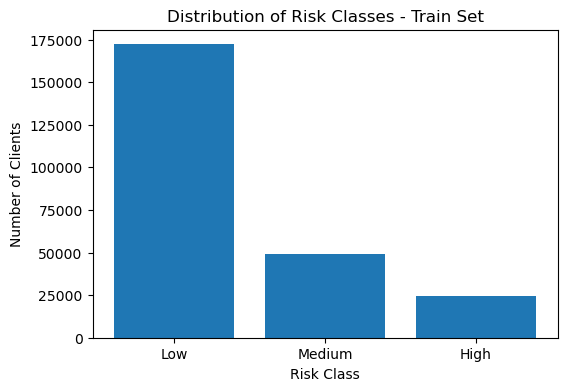

In [133]:
counts = df_train_risk["RISK_CLASS"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.xticks([0,1,2], ["Low","Medium","High"])
plt.title("Distribution of Risk Classes - Train Set")
plt.xlabel("Risk Class")
plt.ylabel("Number of Clients")
plt.show()


### Conclusion of Step 5

We created a new multiclass target `RISK_CLASS`:

- Class 0: Low risk  
- Class 1: Medium risk  
- Class 2: High risk  

This allows training multiclass models, overcomes the binary imbalance, and models credit risk as a spectrum rather than just yes/no.

## 6. Feature Engineering: Integrating Additional Datasets

To improve prediction performance, we integrate additional datasets provided in the Home Credit dataset:

- `bureau.csv` + `bureau_balance.csv` → other credits of the client  
- `previous_application.csv` → previous credit applications  
- `POS_CASH_balance.csv` → point-of-sale and cash loan history  
- `credit_card_balance.csv` → credit card usage history  
- `installments_payments.csv` → loan installment payments  

We will aggregate these datasets per client (`SK_ID_CURR`) and merge them into our main dataset.

In [136]:
# Load main datasets
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
previous = pd.read_csv("previous_application.csv")
pos_cash = pd.read_csv("POS_CASH_balance.csv")
credit_card = pd.read_csv("credit_card_balance.csv")
installments = pd.read_csv("installments_payments.csv")

### 6.1 Aggregation: Bureau & Bureau Balance

We aggregate the client’s other credits and monthly balances to create numeric features per client.  
Categorical columns (`CREDIT_ACTIVE`) are converted to numeric indicators to avoid aggregation errors.

In [63]:
# Select only necessary columns to reduce memory
bureau_small = bureau[['SK_ID_CURR','SK_ID_BUREAU','CREDIT_ACTIVE',
                       'AMT_CREDIT_SUM','CREDIT_DAY_OVERDUE','CNT_CREDIT_PROLONG',
                       'DAYS_CREDIT_ENDDATE','AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM_DEBT',
                       'AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE']].copy()

bureau_balance_small = bureau_balance[['SK_ID_BUREAU','MONTHS_BALANCE','STATUS']].copy()

# Convert categorical to numeric
bureau_small['CREDIT_ACTIVE_NUM'] = (bureau_small['CREDIT_ACTIVE'] == 'Active').astype('int8')
bureau_balance_small['STATUS'] = pd.to_numeric(bureau_balance_small['STATUS'], errors='coerce')

# Aggregate bureau_balance per credit
bureau_bal_agg = bureau_balance_small.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min','max','count'],
    'STATUS': 'mean'
}).astype('float32')
bureau_bal_agg.columns = ['_'.join(col).strip() for col in bureau_bal_agg.columns.values]
bureau_bal_agg.reset_index(inplace=True)

# Merge aggregated bureau_balance with bureau
bureau_small = bureau_small.merge(bureau_bal_agg, on='SK_ID_BUREAU', how='left')

# Aggregate bureau per client
bureau_agg = bureau_small.groupby('SK_ID_CURR').agg({
    'CREDIT_ACTIVE_NUM': 'sum',
    'AMT_CREDIT_SUM': ['mean','max'],
    'CREDIT_DAY_OVERDUE': ['mean','max'],
    'CNT_CREDIT_PROLONG': 'sum',
    'DAYS_CREDIT_ENDDATE': ['min','max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean','max'],
    'AMT_CREDIT_SUM_DEBT': ['mean','max'],
    'AMT_CREDIT_SUM_LIMIT': ['mean','max'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean','max'],
    'MONTHS_BALANCE_min': 'min',
    'MONTHS_BALANCE_max': 'max',
    'STATUS_mean': 'mean'
}).astype('float32')

# Flatten column names
bureau_agg.columns = ['_'.join(col).strip() for col in bureau_agg.columns.values]
bureau_agg.reset_index(inplace=True)

bureau_agg.head()

,SK_ID_CURR,CREDIT_ACTIVE_NUM_sum,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_max,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,DAYS_CREDIT_ENDDATE_min,DAYS_CREDIT_ENDDATE_max,AMT_CREDIT_MAX_OVERDUE_mean,AMT_CREDIT_MAX_OVERDUE_max,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_DEBT_max,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_max,MONTHS_BALANCE_min_min,MONTHS_BALANCE_max_max,STATUS_mean_mean
0,100001,3.0,207623.578125,378000.000000,0.0,0.0,0.0,-1329.0,1778.0,NaN,NaN,85240.929688,373239.0,0.000000,0.000000,0.0,0.0,-51.0,0.0,0.010989
1,100002,2.0,108131.945312,450000.000000,0.0,0.0,0.0,-1072.0,780.0,1681.029053,5043.64502,49156.199219,245781.0,7997.141113,31988.564453,0.0,0.0,-47.0,0.0,0.341806
2,100003,1.0,254350.125000,810000.000000,0.0,0.0,0.0,-2434.0,1216.0,0.000000,0.00000,0.000000,0.0,202500.000000,810000.000000,0.0,0.0,NaN,NaN,NaN
3,100004,0.0,94518.898438,94537.796875,0.0,0.0,0.0,-595.0,-382.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN
4,100005,2.0,219042.000000,568800.000000,0.0,0.0,0.0,-128.0,1324.0,0.000000,0.00000,189469.500000,543087.0,0.000000,0.000000,0.0,0.0,-12.0,0.0,0.000000


### 6.2 Aggregation: Previous Application

We aggregate previous credit applications per client, including number of applications, amounts, and refused applications.

In [65]:
previous_small = previous[['SK_ID_CURR','AMT_APPLICATION','AMT_CREDIT','NAME_CONTRACT_STATUS']].copy()

# Count refused applications
previous_small['REFUSED'] = (previous_small['NAME_CONTRACT_STATUS']=='Refused').astype('int8')

previous_agg = previous_small.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean','max','min'],
    'AMT_CREDIT': ['mean','max','min'],
    'REFUSED': 'sum'
}).astype('float32')

previous_agg.columns = ['_'.join(col).strip() for col in previous_agg.columns.values]
previous_agg.reset_index(inplace=True)

### 6.3 Aggregation: POS_CASH, credit_card, installments

Similarly, we aggregate the remaining datasets to summarize the client history in numeric features.


In [67]:
# POS_CASH
pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['min','max','count'],
    'CNT_INSTALMENT': ['mean','max'],
    'SK_DPD': ['mean','max']
}).astype('float32')
pos_agg.columns = ['_'.join(col).strip() for col in pos_agg.columns.values]
pos_agg.reset_index(inplace=True)

# Credit Card
cc_agg = credit_card.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean','max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean','max'],
    'SK_DPD': ['mean','max']
}).astype('float32')
cc_agg.columns = ['_'.join(col).strip() for col in cc_agg.columns.values]
cc_agg.reset_index(inplace=True)

# Installments
inst_agg = installments.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': ['mean','max','sum'],
    'AMT_PAYMENT': ['mean','max','sum'],
    'DAYS_ENTRY_PAYMENT': ['mean','max']
}).astype('float32')
inst_agg.columns = ['_'.join(col).strip() for col in inst_agg.columns.values]
inst_agg.reset_index(inplace=True)

### 6.4 Merge All Features into Main Dataset

We merge all aggregated datasets into the main dataset using `SK_ID_CURR`.

In [75]:
# Load main training dataset
application_train = pd.read_csv("application_train.csv")

# Memory optimization
# Convert int64 → int32
for col in application_train.select_dtypes(include=["int64"]).columns:
    application_train[col] = application_train[col].astype("int32")

# Convert float64 → float32
for col in application_train.select_dtypes(include=["float64"]).columns:
    application_train[col] = application_train[col].astype("float32")

# Convert object → category
for col in application_train.select_dtypes(include=["object"]).columns:
    application_train[col] = application_train[col].astype("category")

# Create final dataset
df_final = application_train.copy()

# Merge aggregated tables
df_final = df_final.merge(bureau_agg, how="left", on="SK_ID_CURR")
df_final = df_final.merge(previous_agg, how="left", on="SK_ID_CURR")
df_final = df_final.merge(pos_agg, how="left", on="SK_ID_CURR")      # POS_CASH
df_final = df_final.merge(inst_agg, how="left", on="SK_ID_CURR")     # Installments
df_final = df_final.merge(cc_agg, how="left", on="SK_ID_CURR")       # Credit Card

df_final.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_PAYMENT_max,AMT_PAYMENT_sum,DAYS_ENTRY_PAYMENT_mean,DAYS_ENTRY_PAYMENT_max,AMT_BALANCE_mean,AMT_BALANCE_max,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_CREDIT_LIMIT_ACTUAL_max,SK_DPD_mean_y,SK_DPD_max_y
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,53093.746094,2.196257e+05,-315.421051,-49.0,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,560835.375000,1.618865e+06,-1385.319946,-544.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,10573.964844,2.128846e+04,-761.666687,-727.0,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,691786.875000,1.007153e+06,-271.625000,-12.0,0.0,0.0,270000.0,270000.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,22678.785156,8.061280e+05,-1032.242432,-14.0,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Après df_final = df_final.merge(agg_df, on='SK_ID_CURR', how='left')
# Ajoutez ces vérifications :

print("=" * 60)
print("VÉRIFICATION DES IDENTIFIANTS CLIENTS")
print("=" * 60)

# 1. Vérifiez les premières valeurs de SK_ID_CURR
print("\n1. SK_ID_CURR dans df_final (premiers 10):")
print(df_final['SK_ID_CURR'].head(10).values)

# 2. Comparez avec les SK_ID_CURR originaux de X_train
print("\n2. SK_ID_CURR dans X_train original (premiers 10):")
print(X_train['SK_ID_CURR'].head(10).values)

# 3. Vérifiez si tous les ID de X_train sont présents dans df_final
ids_x_train = set(X_train['SK_ID_CURR'].values)
ids_df_final = set(df_final['SK_ID_CURR'].values)

print("\n3. Comparaison des ensembles d'ID :")
print(f"Nombre d'ID dans X_train : {len(ids_x_train)}")
print(f"Nombre d'ID dans df_final : {len(ids_df_final)}")
print(f"IDs manquants dans df_final : {len(ids_x_train - ids_df_final)}")
print(f"IDs supplémentaires dans df_final : {len(ids_df_final - ids_x_train)}")

if len(ids_x_train - ids_df_final) == 0:
    print("✓ TOUS les IDs de X_train sont présents dans df_final")
else:
    print("✗ ATTENTION : Certains IDs de X_train ne sont pas dans df_final")
    print("IDs manquants (5 premiers) :", list(ids_x_train - ids_df_final)[:5])

# 4. Vérifiez les doublons
print("\n4. Vérification des doublons :")
print(f"Nombre de doublons de SK_ID_CURR dans df_final : {df_final['SK_ID_CURR'].duplicated().sum()}")
if df_final['SK_ID_CURR'].duplicated().any():
    print("Doublons trouvés (exemple) :")
    duplicates = df_final[df_final['SK_ID_CURR'].duplicated(keep=False)]
    print(duplicates[['SK_ID_CURR']].head(10))

# 5. Vérifiez le type de merge
print("\n5. Informations sur le merge :")
print(f"Shape initial de X_train : {X_train.shape}")
print(f"Shape final après merge : {df_final.shape}")
print(f"Nombre de colonnes ajoutées : {df_final.shape[1] - X_train.shape[1]}")

# 6. Vérifiez les valeurs manquantes après merge
print("\n6. Valeurs manquantes après merge :")
missing_after_merge = df_final.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes : {missing_after_merge}")
print(f"Pourcentage de valeurs manquantes : {missing_after_merge/(df_final.shape[0]*df_final.shape[1]):.2%}")

# 7. Affichez quelques lignes avec les nouvelles features
print("\n7. Exemple de données avec nouvelles features (3 premières lignes) :")
sample_cols = ['SK_ID_CURR'] + [col for col in df_final.columns if col.startswith(('CREDIT', 'AMT', 'POS', 'CC', 'INST'))][:10]
print(df_final[sample_cols].head(3).to_string())

# 8. Vérifiez que TARGET existe toujours si nécessaire
if 'TARGET' in X_train.columns:
    print("\n8. Vérification de la variable TARGET :")
    print(f"TARGET présent dans X_train : {'TARGET' in X_train.columns}")
    print(f"TARGET présent dans df_final : {'TARGET' in df_final.columns}")
    if 'TARGET' in df_final.columns:
        print("Distribution de TARGET :")
        print(df_final['TARGET'].value_counts(normalize=True))

VÉRIFICATION DES IDENTIFIANTS CLIENTS

1. SK_ID_CURR dans df_final (premiers 10):
[100002 100003 100004 100006 100007 100008 100009 100010 100011 100012]

2. SK_ID_CURR dans X_train original (premiers 10):
[ 0.31477263  0.84964952 -0.35144971  1.71916983  1.65522393  0.53362659
 -0.75745221  0.80500511 -1.24995144  0.97941895]

3. Comparaison des ensembles d'ID :
Nombre d'ID dans X_train : 246008
Nombre d'ID dans df_final : 307511
IDs manquants dans df_final : 246008
IDs supplémentaires dans df_final : 307511
✗ ATTENTION : Certains IDs de X_train ne sont pas dans df_final
IDs manquants (5 premiers) : [-0.49913916213404264, 1.2642812631227116, 1.466256147261447, 1.3423822394661329, 1.2368175042515759]

4. Vérification des doublons :
Nombre de doublons de SK_ID_CURR dans df_final : 0

5. Informations sur le merge :
Shape initial de X_train : (246008, 155)
Shape final après merge : (307511, 169)
Nombre de colonnes ajoutées : 14

6. Valeurs manquantes après merge :
Nombre total de valeurs 

### Conclusion of Step 6

We have successfully integrated all additional datasets into the main dataset.  
The enriched dataset now contains numerical features summarizing client credit history, previous applications, cash loans, credit card usage, and installment payments.  
This enriched dataset is ready for final preprocessing and for building multiclass credit risk models.

## 7. Final Pre-processing and Multiclass Modeling  

In this step, we finalize the preprocessing on the enriched dataset, apply dimensionality reduction techniques such as PCA, and build multiple multiclass classification models to predict the `RISK_CLASS` variable. 
This includes hyperparameter tuning, model evaluation, and a comparison between models trained with and without PCA.

### 7.1 Final Pre-processing
 
After integrating bureau, previous applications, POS_CASH, credit card, and installments data into the main dataset, we apply a final round of preprocessing to prepare the enriched dataset for multiclass modeling.  

In [144]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Copy dataset
df_model = df_final.copy()

# Target variable
y = df_model['RISK_CLASS']

# Drop ID and TARGET if exists
drop_cols = ['RISK_CLASS', 'SK_ID_CURR']
if 'TARGET' in df_model.columns:
    drop_cols.append('TARGET')

X = df_model.drop(columns=drop_cols)

# Remove constant columns
constant_cols = [col for col in X.columns if X[col].nunique() <= 1]
X.drop(columns=constant_cols, inplace=True)

# Remove duplicated columns
X = X.loc[:,~X.columns.duplicated()]

# Encode categorical variables
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Scale numerical features (excluding encoded categorical)
num_cols = X.select_dtypes(include=['float32', 'float64']).columns.tolist()
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Stratified train/test split for multiclass
X_train_final, X_test_final, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check shapes
print("X_train shape:", X_train_final.shape)
print("X_test shape:", X_test_final.shape)
print("Class distribution in y_train:\n", y_train.value_counts(normalize=True))

KeyError: 'RISK_CLASS'

### 7.2 Principal Component Analysis (PCA)

We apply PCA to reduce dimensionality and multicollinearity among numerical features.